In [2]:
import pandas as pd
# loading the dataset
day_ds = pd.read_csv('data/day.csv')
hour_ds = pd.read_csv('data/hour.csv')

In [3]:
hour_ds

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing

# preprocessing the data

# extracting day of week
hour_ds['dteday'] = pd.to_datetime(hour_ds['dteday'])
hour_ds['day of week'] = hour_ds['dteday'].dt.dayofweek

# extracting cyclical features using sine and cosine transformations
cyclical_features = ['season', 'mnth', 'weekday', 'hr']
for feature in cyclical_features:
  hour_ds[f'{feature}_sin'] = np.sin(2 * np.pi * hour_ds[feature] / hour_ds[feature].max())
  hour_ds[f'{feature}_cos'] = np.cos(2 * np.pi * hour_ds[feature] / hour_ds[feature].max())

# creating binary variables for time indicators
hour_ds['afternoon'] = np.where((hour_ds['hr'] >= 12) & (hour_ds['hr'] <= 18), 1, 0)
hour_ds['working hour'] = np.where((hour_ds['hr'] >= 9) & (hour_ds['hr'] <= 17), 1, 0)
hour_ds['holiday'] = np.where(hour_ds['holiday'] == 1, 1, 0)
hour_ds['working day'] = np.where(hour_ds['workingday'] == 1, 1, 0)
hour_ds['month start'] = np.where(hour_ds['dteday'].dt.is_month_start, 1, 0)
hour_ds['quarter start'] = np.where(hour_ds['dteday'].dt.is_quarter_start, 1, 0)

# creating lagged values
target = ['cnt', 'casual', 'registered'] # target variables

# lagged (recent)
for feature in target:
  for i in range(1, 4):
    hour_ds[f'{feature}_lag{i}'] = hour_ds[feature].shift(i)

# lagged (distant)
for feature in target:
  for i in [24, 48, 168]:
    hour_ds[f'{feature}_lag{i}'] = hour_ds[feature].shift(i)

print(hour_ds.shape)
hour_df = hour_ds.dropna()
print(hour_df.shape)

(17379, 49)
(17211, 49)


In [5]:
hour_df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,registered_lag3,cnt_lag24,cnt_lag48,cnt_lag168,casual_lag24,casual_lag48,casual_lag168,registered_lag24,registered_lag48,registered_lag168
168,169,2011-01-08,1,0,1,7,0,6,0,2,...,1.0,84.0,36.0,16.0,8.0,0.0,3.0,76.0,36.0,13.0
169,170,2011-01-08,1,0,1,8,0,6,0,3,...,5.0,210.0,95.0,40.0,20.0,0.0,8.0,190.0,95.0,32.0
170,171,2011-01-08,1,0,1,9,0,6,0,3,...,2.0,134.0,219.0,32.0,9.0,3.0,5.0,125.0,216.0,27.0
171,172,2011-01-08,1,0,1,10,0,6,0,2,...,8.0,63.0,122.0,13.0,16.0,6.0,3.0,47.0,116.0,10.0
172,173,2011-01-08,1,0,1,11,0,6,0,2,...,15.0,67.0,45.0,1.0,19.0,3.0,0.0,48.0,42.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,...,184.0,102.0,97.0,26.0,16.0,7.0,6.0,86.0,90.0,20.0
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,...,150.0,72.0,66.0,18.0,9.0,2.0,4.0,63.0,64.0,14.0
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,...,112.0,47.0,60.0,23.0,5.0,4.0,6.0,42.0,56.0,17.0
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,...,108.0,36.0,54.0,22.0,6.0,3.0,13.0,30.0,51.0,9.0


In [6]:
# scaling
scaler = preprocessing.MinMaxScaler()
scaled_features = [
    'season_sin',
    'season_cos',
    'mnth_sin',
    'mnth_cos',
    'weekday_sin',
    'weekday_cos',
    'hr_sin',
    'hr_cos',
    'cnt',
    'casual',
    'registered',
    'cnt_lag1',
    'cnt_lag2',
    'cnt_lag3',
    'cnt_lag24',
    'cnt_lag48',
    'cnt_lag168'
]

# Store the original index
original_index = hour_df.index

scaled_df = pd.DataFrame(scaler.fit_transform(hour_df[scaled_features]), columns=scaled_features)

# Reset the index of scaled_df to match the original DataFrame
scaled_df.index = original_index

# Drop the original features using .loc or .iloc
hour_df = hour_df.loc[:, ~hour_df.columns.isin(scaled_features)]

hour_df = pd.concat([hour_df, scaled_df], axis=1)

# selecting relevant features
final_cols = [
    'season_sin',
    'season_cos',
    'day of week',
    'mnth_sin',
    'mnth_cos',
    'weekday_sin',
    'weekday_cos',
    'hr_sin',
    'hr_cos',
    'holiday',
    'afternoon',
    'working hour',
    'working day',
    'month start',
    'quarter start',
    'cnt_lag1',
    'cnt_lag2',
    'cnt_lag3',
    'cnt_lag24',
    'cnt_lag48',
    'cnt_lag168'
]

target = 'cnt'

hour_df_final = hour_df[final_cols + [target]]

print(hour_df_final.shape)
hour_final = hour_df_final.dropna()
print(hour_final.shape)

(17211, 22)
(17211, 22)


In [7]:
hour_final

,season_sin,season_cos,day of week,mnth_sin,mnth_cos,weekday_sin,weekday_cos,hr_sin,hr_cos,holiday,...,working day,month start,quarter start,cnt_lag1,cnt_lag2,cnt_lag3,cnt_lag24,cnt_lag48,cnt_lag168,cnt
168,1.0,0.5,5,0.75,0.933013,0.5,1.00,0.972231,3.294374e-01,0,...,0,0,0,0.001025,0.004098,0.000000,0.085041,0.035861,0.015369,0.008197
169,1.0,0.5,5,0.75,0.933013,0.5,1.00,0.909439,2.079713e-01,0,...,0,0,0,0.008197,0.001025,0.004098,0.214139,0.096311,0.039959,0.014344
170,1.0,0.5,5,0.75,0.933013,0.5,1.00,0.816281,1.079902e-01,0,...,0,0,0,0.014344,0.008197,0.001025,0.136270,0.223361,0.031762,0.019467
171,1.0,0.5,5,0.75,0.933013,0.5,1.00,0.699666,3.690921e-02,0,...,0,0,0,0.019467,0.014344,0.008197,0.063525,0.123975,0.012295,0.061475
172,1.0,0.5,5,0.75,0.933013,0.5,1.00,0.568242,5.551115e-17,0,...,0,0,0,0.061475,0.019467,0.014344,0.067623,0.045082,0.000000,0.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1.0,0.5,0,0.50,1.000000,1.0,0.75,0.055020,7.287694e-01,0,...,1,0,0,0.123975,0.167008,0.218238,0.103484,0.098361,0.025615,0.120902
17375,1.0,0.5,0,0.50,1.000000,1.0,0.75,0.133728,8.405339e-01,0,...,1,0,0,0.120902,0.123975,0.167008,0.072746,0.066598,0.017418,0.090164
17376,1.0,0.5,0,0.50,1.000000,1.0,0.75,0.239601,9.268691e-01,0,...,1,0,0,0.090164,0.120902,0.123975,0.047131,0.060451,0.022541,0.091189
17377,1.0,0.5,0,0.50,1.000000,1.0,0.75,0.364786,9.813719e-01,0,...,1,0,0,0.091189,0.090164,0.120902,0.035861,0.054303,0.021516,0.061475


In [8]:
import numpy as np
import keras

class SequenceDataGenerator(keras.utils.Sequence):
    def __init__(self, data, targets, sequence_length, batch_size):
        self.data = data
        self.targets = targets
        self.sequence_length = sequence_length
        self.batch_size = batch_size

    def __len__(self):
        return (len(self.data) - self.sequence_length) // self.batch_size

    def __getitem__(self, idx):
        start_index = idx * self.batch_size
        batch_x = []
        batch_y = []
        for i in range(start_index, start_index + self.batch_size):
            end_index = i + self.sequence_length
            if end_index < len(self.data) and (end_index - 1) < len(self.targets):
                seq_x = self.data[i:end_index]
                seq_y = self.targets[end_index - 1]
                batch_x.append(seq_x)
                batch_y.append(seq_y)
        return np.array(batch_x), np.array(batch_y)
    def get_all_y_values(self):
        all_y_values = []
        for idx in range(len(self)):
            _, batch_y = self[idx]
            all_y_values.extend(batch_y)
        return np.array(all_y_values)


In [9]:
# generating multi-step forecasts for the first 100 steps of test set using only 16 steps
def multistep_forecasts_in_train(model, X, n_steps, X_known):
    forecasts = []
    current_input = np.array(X)
    for i in range(current_input.shape[0]):
      forecasts.append([])

    for i in range(n_steps):
      sum_of_predictions = []
      forecast_step = model.predict(current_input)

      for k in range(forecast_step.shape[0]):
        forecasts[k].append(forecast_step[k][0])
        current_input[k] = np.roll(current_input[k], shift=-1, axis=0)
        #Update new input accordingly
        for t in range(15):
          current_input[k, -1, t] = X_known[k][i][t]
        current_input[k, -1, 15] = forecast_step[k][0]
        current_input[k, -1, 16] = current_input[k, -2, 15]
        current_input[k, -1, 17] = current_input[k, -2, 16]

        #This part doesn't work too good, better approach may be used---------------------------------------------------
        if i >= 24 and i <  24 + current_input.shape[1]:
          current_input[k, -1, 18] = X[k][i - 24][15]
          current_input[k, -1, 19] = X[k][i - 24][18]
        if i >= 48 and i <  48 + current_input.shape[1]:
          current_input[k, -1, 19] = X[k][i - 48][15]
        if i >= 96 and i <  96 + current_input.shape[1]:
          current_input[k, -1, 20] = X[k][i - 96][19]

    flattened_forecasts = [item for sublist in forecasts for item in sublist]


    return np.array(flattened_forecasts)

In [10]:
#Original Model
import random


from sklearn.model_selection import train_test_split
from sklearn.utils import resample
# references: https://carpentries-incubator.github.io/machine-learning-novice-python/07-bootstrapping/index.html

sequence_length = 16
batch_size = 128

# splitting the data into train and test (70% and 30%)
split_point = int(len(hour_final) * 0.7)
train_set, future_test_set = train_test_split(hour_final, test_size=0.3, shuffle=False)
X_test = future_test_set[final_cols]
expected_shape_test = ((X_test.shape[0] // 16) * 16)

y_test = future_test_set[target]

# evaluation
test_generator = SequenceDataGenerator(X_test.values, y_test.values, sequence_length, batch_size)


# storing training and validation sets during bootstrapping
train_sets = []
val_sets = []

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers.legacy import Adam

# Initialize lists to store models and their predictions
baseline_trained_models = []
baseline_predictions = []

# Bootstrapping and training loop
bootstrap_samples = 5 #For test purposes, real value is 50
for i in range(bootstrap_samples):
    # Sequential train-test split for time series data
    random_float = random.uniform(0, 0.2)

    # Calculate the start and end indices for the validation set
    total_length = len(train_set)
    val_start = int(total_length * random_float)
    val_end = int(total_length * (random_float + 0.8))

    # Ensure val_end does not exceed the total length of the dataset
    val_end = min(val_end, total_length)

    # Split the data into training and validation sets
    train_set_i = train_set[val_start:val_end]
    val_set = pd.concat([train_set[:val_start], train_set[val_end:]])



    # Bootstrap sampling
    X_train = train_set_i[final_cols]
    y_train = train_set_i[target]
    y_train_adjusted = y_train[15:]
    train_generator = SequenceDataGenerator(X_train.values, y_train.values, sequence_length, batch_size)

    X_val = val_set[final_cols]
    y_val = val_set[target]
    y_val_adjusted = y_val[15:]
    val_generator = SequenceDataGenerator(X_val.values, y_val.values, sequence_length, batch_size)

    # Build a new LSTM model
    model = Sequential()
    model.add(LSTM(units=32, input_shape=(16, X_train.shape[1]), dropout=0.5))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the model
    model.fit(train_generator, epochs=128, validation_data=val_generator, shuffle=True) #epoch must be 128

    # Store the trained model
    baseline_trained_models.append(model)

    # Evaluate the model on the test set and store predictions

    n_steps = 100
    input_size = 16
    max_steps = (X_test.shape[0] - input_size - n_steps) // (n_steps)
    step = 0
    test_inputs = []
    test_outputs = []

    for step in range(max_steps):
      # Starting index for test_values
      start_idx = step * (n_steps)

      # Extracting the input_size elements for test_values
      test_input = X_test.values[start_idx:start_idx + input_size].reshape((input_size, X_test.shape[1]))
      test_inputs.append(test_input)

      # Starting index for test_outputs is immediately after test_value
      output_start_idx = start_idx + input_size

      # Extracting the n_steps elements for test_outputs
      test_output = X_test.values[output_start_idx:output_start_idx + n_steps]
      test_outputs.append(test_output)

    model_predictions = multistep_forecasts_in_train(model, test_inputs, n_steps, test_outputs)

    #model_predictions = model.predict(test_generator)
    baseline_predictions.append(model_predictions)

    print("Finished sample " + str(i+1))

# You can now use the stored predictions to calculate prediction intervals

Epoch 1/128
75/75 [==============================] - 1s 6ms/step - loss: 0.0328 - val_loss: 0.0192
Epoch 2/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0145 - val_loss: 0.0133
Epoch 3/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0121 - val_loss: 0.0120
Epoch 4/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0112 - val_loss: 0.0102
Epoch 5/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0106 - val_loss: 0.0092
Epoch 6/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0099 - val_loss: 0.0095
Epoch 7/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0096 - val_loss: 0.0146
Epoch 8/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.0086
Epoch 9/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 10/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0087 - val_loss: 0.0094
Epoch 11/

Epoch 1/128
75/75 [==============================] - 1s 6ms/step - loss: 0.0628 - val_loss: 0.0245
Epoch 2/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0192 - val_loss: 0.0179
Epoch 3/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0144 - val_loss: 0.0133
Epoch 4/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0129 - val_loss: 0.0112
Epoch 5/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0118 - val_loss: 0.0109
Epoch 6/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0111 - val_loss: 0.0095
Epoch 7/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0105 - val_loss: 0.0089
Epoch 8/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0102 - val_loss: 0.0086
Epoch 9/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0098 - val_loss: 0.0083
Epoch 10/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0086
Epoch 11/

Epoch 1/128
75/75 [==============================] - 1s 6ms/step - loss: 0.0418 - val_loss: 0.0231
Epoch 2/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0125 - val_loss: 0.0199
Epoch 3/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0104 - val_loss: 0.0164
Epoch 4/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.0151
Epoch 5/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0087 - val_loss: 0.0143
Epoch 6/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0083 - val_loss: 0.0135
Epoch 7/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0084 - val_loss: 0.0141
Epoch 8/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0083 - val_loss: 0.0135
Epoch 9/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0081 - val_loss: 0.0134
Epoch 10/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0135
Epoch 11/

Epoch 1/128
75/75 [==============================] - 1s 7ms/step - loss: 0.0221 - val_loss: 0.0154
Epoch 2/128
75/75 [==============================] - 0s 5ms/step - loss: 0.0132 - val_loss: 0.0102
Epoch 3/128
75/75 [==============================] - 0s 5ms/step - loss: 0.0113 - val_loss: 0.0090
Epoch 4/128
75/75 [==============================] - 0s 5ms/step - loss: 0.0105 - val_loss: 0.0079
Epoch 5/128
75/75 [==============================] - 0s 5ms/step - loss: 0.0099 - val_loss: 0.0086
Epoch 6/128
75/75 [==============================] - 0s 5ms/step - loss: 0.0101 - val_loss: 0.0074
Epoch 7/128
75/75 [==============================] - 0s 5ms/step - loss: 0.0096 - val_loss: 0.0073
Epoch 8/128
75/75 [==============================] - 0s 5ms/step - loss: 0.0094 - val_loss: 0.0073
Epoch 9/128
75/75 [==============================] - 0s 5ms/step - loss: 0.0091 - val_loss: 0.0076
Epoch 10/128
75/75 [==============================] - 0s 5ms/step - loss: 0.0083 - val_loss: 0.0092
Epoch 11/

Epoch 1/128
75/75 [==============================] - 1s 6ms/step - loss: 0.0455 - val_loss: 0.0164
Epoch 2/128
75/75 [==============================] - 0s 5ms/step - loss: 0.0129 - val_loss: 0.0105
Epoch 3/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0115 - val_loss: 0.0107
Epoch 4/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0106 - val_loss: 0.0087
Epoch 5/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0103 - val_loss: 0.0086
Epoch 6/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0089
Epoch 7/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0101 - val_loss: 0.0090
Epoch 8/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.0086
Epoch 9/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0094 - val_loss: 0.0097
Epoch 10/128
75/75 [==============================] - 0s 4ms/step - loss: 0.0089 - val_loss: 0.0078
Epoch 11/

In [11]:
from sklearn.metrics import median_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

# evaluation
def evaluate_pred(predictions, actual):
  rmses, smapes, r_sqs, msaes, medaes, accs, precs, recalls, f1s = [], [], [], [], [], [], [], [], []

  yt = np.zeros_like(actual, dtype=int)

  for i in range(1, actual.shape[0]):
    if (actual[i] - actual[i-1] > 0):
      yt[i] = 1

  for pred in predictions:
    pred_flat = pred.flatten()

    yet = np.zeros_like(pred_flat, dtype=int)
    for i in range(1, pred_flat.shape[0]):
      if (pred_flat[i] - actual[i-1] > 0):
        yet[i] = 1

    errors = pred_flat - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)

    smape = (100 / len(pred)) * np.sum(2 * np.abs(pred_flat - actual) / (np.abs(actual) + np.abs(pred_flat)))

    r_squared = r2_score(actual, pred_flat)

    mae = np.abs(errors).mean()

    medae = median_absolute_error(actual, pred_flat)

    acc = accuracy_score(yt, yet)

    prec = precision_score(yt, yet, average='binary')

    recall = recall_score(yt, yet, average='binary' )

    f1 = f1_score(yt, yet, average='binary' )

    rmses.append(rmse)
    smapes.append(smape)
    r_sqs.append(r_squared)
    msaes.append(mae)
    medaes.append(medae)
    accs.append(acc)
    precs.append(prec)
    recalls.append(recall)
    f1s.append(f1)

  rmse = np.mean(rmses)
  smape = np.mean(smapes)
  r_squared = np.mean(r_sqs)
  mae = np.mean(msaes)
  medae = np.mean(medaes)
  acc = np.mean(accs)
  prec = np.mean(precs)
  recall = np.mean(recalls)
  f1 = np.mean(f1s)

  return rmse, smape, r_squared, mae, medae, acc, prec, recall, f1

n_steps = 100
input_size = 16
max_steps = (X_test.shape[0] - input_size - n_steps) // (n_steps)
baseline_actual = y_test.values[input_size:(max_steps) * n_steps + input_size]

rmse, smape, r_squared, mae, medae, acc, prec, recall, f1 = evaluate_pred(baseline_predictions, baseline_actual)

metrics_df = pd.DataFrame({
    "Metric": ["RMSE", "SMAPE", "R^2", "MAE", "MedAE", "Accuracy", "Precision", "Recall", "F1"],
    "Value": [100 * rmse, smape, r_squared, 100 * mae, 100 * medae, acc, prec, recall, f1]
})

print('Baseline Model Evaluation (5 Bootstraps)')
print(metrics_df)

# loss = baseline_trained_models[0].evaluate(X_test_reshaped, y_test_adjusted)
# print(f'Baseline Model Loss on Test Set: {loss}')

Baseline Model Evaluation (5 Bootstraps)
      Metric      Value
0       RMSE  17.828969
1      SMAPE  65.437273
2        R^2   0.374035
3        MAE  12.415359
4      MedAE   8.039101
5   Accuracy   0.606400
6  Precision   0.551548
7     Recall   0.543498
8         F1   0.544281


In [12]:
rmse, smape, r_squared, mae, medae, acc, prec, recall, f1 = evaluate_pred([baseline_predictions[0]], baseline_actual)

metrics_df = pd.DataFrame({
    "Metric": ["RMSE", "SMAPE", "R^2", "MAE", "MedAE", "Accuracy", "Precision", "Recall", "F1"],
    "Value": [100 * rmse, smape, r_squared, 100 * mae, 100 * medae, acc, prec, recall, f1]
})

print('Baseline Model Evaluation (No Bootstraps)')
print(metrics_df)

Baseline Model Evaluation (No Bootstraps)
      Metric      Value
0       RMSE  18.597411
1      SMAPE  67.797756
2        R^2   0.326082
3        MAE  13.108848
4      MedAE   8.883925
5   Accuracy   0.592600
6  Precision   0.533213
7     Recall   0.540293
8         F1   0.536730


In [13]:
def extract_sequences(data, sequence_length, num_sequences):
    sequences = []
    for i in range(num_sequences):
        # Check if we can extract a full sequence of the desired length
        if i + sequence_length <= len(data):
            sequence = data[i:i + sequence_length]
            sequences.append(sequence)
        else:
            break  # Break if we reach the end of the data
    return np.array(sequences)

# Extract 100 sequences of 16 time steps
sequence_length = 16
num_sequences = 100
X_test_sequences = extract_sequences(X_test.values, sequence_length, num_sequences)

In [14]:
# generating multi-step forecasts for the first 100 steps of test set using only 16 steps
def multistep_forecasts(models, X, n_steps, X_known):
    forecasts = []
    current_input = X.reshape(1, X.shape[0], X.shape[1])

    for i in range(n_steps):
      sum_of_predictions = 0
      for model_i in range(len(models)):
        forecast_step = models[model_i].predict(current_input.reshape(1, current_input.shape[1], current_input.shape[2]))
        sum_of_predictions += forecast_step[0, 0]
      forecasts.append(sum_of_predictions / len(models))

      # Update the input for the next time step
      current_input = np.roll(current_input, shift=-1, axis=1)

      #Update new input accordingly
      for k in range(15):
        current_input[0, -1, k] = X_known[i, k]
      current_input[0, -1, 15] = sum_of_predictions / len(models)
      current_input[0, -1, 16] = current_input[0, -2, 15]
      current_input[0, -1, 17] = current_input[0, -2, 16]

      #This part doesn't work too good, better approach may be used---------------------------------------------------
      if i >= 24 and i <  24 + current_input.shape[1]:
        current_input[0, -1, 18] = X[i - 24][15]
        current_input[0, -1, 19] = X[i - 24][18]
      if i >= 48 and i <  48 + current_input.shape[1]:
        current_input[0, -1, 19] = X[i - 48][15]
      if i >= 96 and i <  96 + current_input.shape[1]:
        current_input[0, -1, 20] = X[i - 96][19]


    return np.array(forecasts)

In [15]:
n_steps = 100
X_test_reshaped = X_test.values[:expected_shape_test].reshape((X_test.shape[0] // 16, 16, X_test.shape[1]))
multi_step_forecasts = multistep_forecasts(baseline_trained_models, X_test_reshaped[0], n_steps, X_test.values[16:16+n_steps])

1/1 [==============================] - 0s 10ms/step


In [16]:
n_steps = 100
X_test_reshaped = X_test.values[:expected_shape_test].reshape((X_test.shape[0] // 16, 16, X_test.shape[1]))
multi_step_forecasts_no_bootstrap = multistep_forecasts([baseline_trained_models[0]], X_test_reshaped[0], n_steps, X_test.values[16:16+n_steps])

1/1 [==============================] - 0s 8ms/step


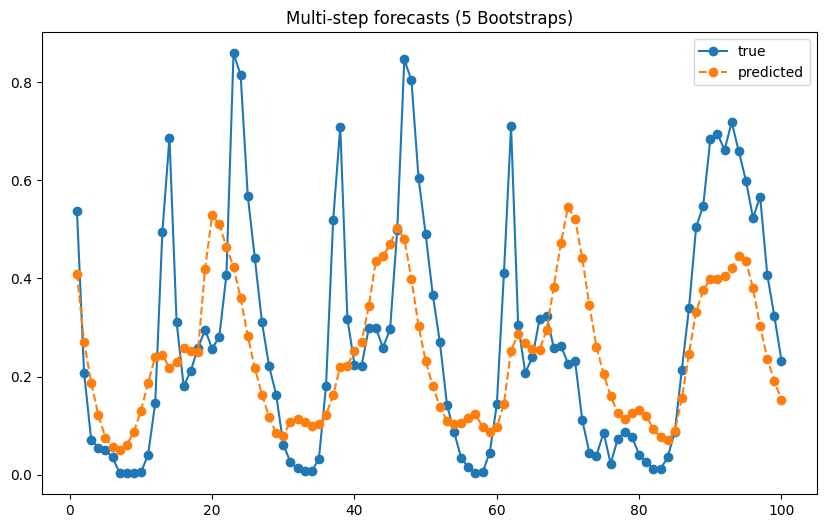

In [19]:
import matplotlib.pyplot as plt

# plotting true and predicted lines for each set of forecasts
# multi-step
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 101), y_test[sequence_length - 1 :num_sequences + sequence_length - 1], label='true', marker='o', linestyle='-')
plt.plot(np.arange(1, 101), multi_step_forecasts[:100], label='predicted', marker='o', linestyle='--')
plt.title('Multi-step forecasts (5 Bootstraps)')
plt.legend()
plt.show()

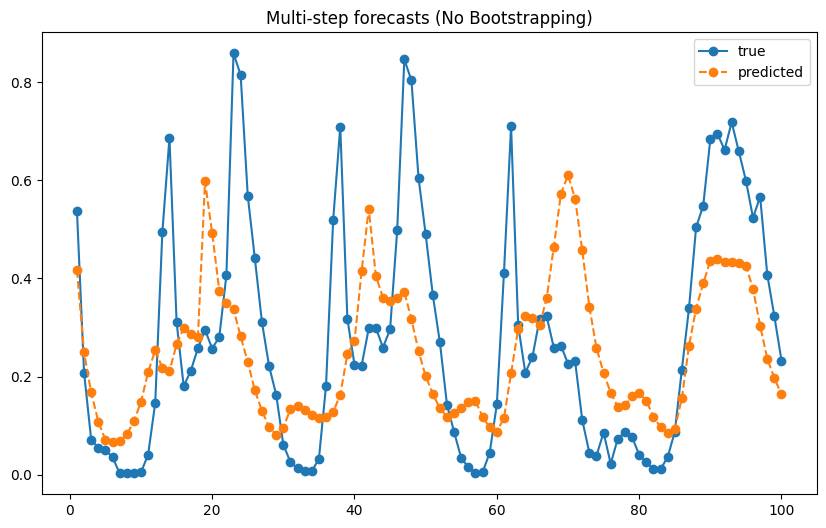

In [18]:
# multi-step
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 101), y_test[sequence_length - 1 :num_sequences + sequence_length - 1], label='true', marker='o', linestyle='-')
plt.plot(np.arange(1, 101), multi_step_forecasts_no_bootstrap[:100], label='predicted', marker='o', linestyle='--')
plt.title('Multi-step forecasts (No Bootstrapping)')
plt.legend()
plt.show()

In [20]:
class SequenceDataGeneratorBatchOverlap(keras.utils.Sequence):
    def __init__(self, data, targets, sequence_length, batch_size, overlap_size):
        self.data = data
        self.targets = targets
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.overlap_size = overlap_size

    def __len__(self):
        # Adjust the length calculation to account for overlap
        total_sequences = len(self.data) - self.sequence_length + 1
        return (total_sequences - self.overlap_size) // (self.batch_size - self.overlap_size)

    def __getitem__(self, idx):
        start_index = idx * (self.batch_size - self.overlap_size)
        batch_x = []
        batch_y = []
        for i in range(start_index, start_index + self.batch_size):
            end_index = i + self.sequence_length
            if end_index <= len(self.data):
                seq_x = self.data[i:end_index]
                seq_y = self.targets[end_index - 1] if (end_index - 1) < len(self.targets) else None
                if seq_y is not None:
                    batch_x.append(seq_x)
                    batch_y.append(seq_y)
        return np.array(batch_x), np.array(batch_y)

In [21]:
#Overlap model
import random


from sklearn.model_selection import train_test_split
from sklearn.utils import resample
# references: https://carpentries-incubator.github.io/machine-learning-novice-python/07-bootstrapping/index.html

sequence_length = 16
batch_size = 128

# splitting the data into train and test (70% and 30%)
split_point = int(len(hour_final) * 0.7)
train_set, future_test_set = train_test_split(hour_final, test_size=0.3, shuffle=False)
X_test = future_test_set[final_cols]
expected_shape_test = (X_test.shape[0] // 16) * 16

y_test = future_test_set[target]
y_test_adjusted = y_test[15:]

# evaluation
test_generator = SequenceDataGenerator(X_test.values, y_test.values, sequence_length, batch_size)


# storing training and validation sets during bootstrapping
train_sets = []
val_sets = []

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Initialize lists to store models and their predictions
bo_trained_models = []
bo_predictions = []

# Bootstrapping and training loop
bootstrap_samples = 5 #For test purposes, real value is 50
for i in range(bootstrap_samples):
    # Sequential train-test split for time series data
    random_float = random.uniform(0, 0.2)

    # Calculate the start and end indices for the validation set
    total_length = len(train_set)
    val_start = int(total_length * random_float)
    val_end = int(total_length * (random_float + 0.8))

    # Ensure val_end does not exceed the total length of the dataset
    val_end = min(val_end, total_length)

    # Split the data into training and validation sets
    train_set_i = train_set[val_start:val_end]
    val_set = pd.concat([train_set[:val_start], train_set[val_end:]])



    # Bootstrap sampling
    X_train = train_set_i[final_cols]
    y_train = train_set_i[target]
    y_train_adjusted = y_train[15:]
    train_generator = SequenceDataGeneratorBatchOverlap(X_train.values, y_train.values, sequence_length, batch_size, 16)

    X_val = val_set[final_cols]
    y_val = val_set[target]
    y_val_adjusted = y_val[15:]
    val_generator = SequenceDataGenerator(X_val.values, y_val.values, sequence_length, batch_size)

    # Build a new LSTM model
    model = Sequential()
    model.add(LSTM(units=32, input_shape=(16, X_train.shape[1]), dropout=0.5))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the model
    model.fit(train_generator, epochs=128, validation_data=val_generator, shuffle=True) #epoch must be 128

    # Store the trained model
    bo_trained_models.append(model)

    # Evaluate the model on the test set and store predictions
    # Note: Replace X_test_reshaped and y_test with your actual test data reshaped accordingly

    # Evaluate the model on the test set and store predictions

    n_steps = 100
    input_size = 16
    max_steps = (X_test.shape[0] - input_size - n_steps) // (n_steps)
    step = 0
    test_inputs = []
    test_outputs = []

    for step in range(max_steps):
      # Starting index for test_values
      start_idx = step * (n_steps)

      # Extracting the input_size elements for test_values
      test_input = X_test.values[start_idx:start_idx + input_size].reshape((input_size, X_test.shape[1]))
      test_inputs.append(test_input)

      # Starting index for test_outputs is immediately after test_value
      output_start_idx = start_idx + input_size

      # Extracting the n_steps elements for test_outputs
      test_output = X_test.values[output_start_idx:output_start_idx + n_steps]
      test_outputs.append(test_output)

    model_predictions = multistep_forecasts_in_train(model, test_inputs, n_steps, test_outputs)
    bo_predictions.append(model_predictions)

    print("Finished sample " + str(i+1))

# You can now use the stored predictions to calculate prediction intervals


Epoch 1/128
85/85 [==============================] - 1s 6ms/step - loss: 0.0365 - val_loss: 0.0097
Epoch 2/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0149 - val_loss: 0.0068
Epoch 3/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0128 - val_loss: 0.0079
Epoch 4/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0120 - val_loss: 0.0061
Epoch 5/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0112 - val_loss: 0.0074
Epoch 6/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0110 - val_loss: 0.0089
Epoch 7/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0105 - val_loss: 0.0059
Epoch 8/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0101 - val_loss: 0.0075
Epoch 9/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0068
Epoch 10/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0097 - val_loss: 0.0075
Epoch 11/

Epoch 1/128
85/85 [==============================] - 1s 7ms/step - loss: 0.0249 - val_loss: 0.0157
Epoch 2/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0136 - val_loss: 0.0142
Epoch 3/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0114 - val_loss: 0.0098
Epoch 4/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0110 - val_loss: 0.0091
Epoch 5/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0102 - val_loss: 0.0092
Epoch 6/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0098 - val_loss: 0.0095
Epoch 7/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0097 - val_loss: 0.0112
Epoch 8/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0091 - val_loss: 0.0083
Epoch 9/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 10/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0085 - val_loss: 0.0102
Epoch 11/

Epoch 1/128
85/85 [==============================] - 1s 7ms/step - loss: 0.0222 - val_loss: 0.0149
Epoch 2/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0124 - val_loss: 0.0111
Epoch 3/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0113 - val_loss: 0.0094
Epoch 4/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0101 - val_loss: 0.0093
Epoch 5/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 6/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.0082
Epoch 7/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0092 - val_loss: 0.0087
Epoch 8/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0088 - val_loss: 0.0081
Epoch 9/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 10/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0087 - val_loss: 0.0087
Epoch 11/

Epoch 1/128
85/85 [==============================] - 1s 6ms/step - loss: 0.0203 - val_loss: 0.0197
Epoch 2/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0117 - val_loss: 0.0163
Epoch 3/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0099 - val_loss: 0.0152
Epoch 4/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0092 - val_loss: 0.0116
Epoch 5/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0089 - val_loss: 0.0134
Epoch 6/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0085 - val_loss: 0.0129
Epoch 7/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0084 - val_loss: 0.0118
Epoch 8/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0116
Epoch 9/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0078 - val_loss: 0.0149
Epoch 10/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0074 - val_loss: 0.0117
Epoch 11/

Epoch 1/128
85/85 [==============================] - 1s 7ms/step - loss: 0.0257 - val_loss: 0.0153
Epoch 2/128
85/85 [==============================] - 0s 5ms/step - loss: 0.0138 - val_loss: 0.0121
Epoch 3/128
85/85 [==============================] - 0s 5ms/step - loss: 0.0122 - val_loss: 0.0093
Epoch 4/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0108 - val_loss: 0.0083
Epoch 5/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0105 - val_loss: 0.0075
Epoch 6/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0097 - val_loss: 0.0086
Epoch 7/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0094 - val_loss: 0.0073
Epoch 8/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0088 - val_loss: 0.0069
Epoch 9/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0085 - val_loss: 0.0065
Epoch 10/128
85/85 [==============================] - 0s 4ms/step - loss: 0.0082 - val_loss: 0.0078
Epoch 11/

In [22]:
def reshape_with_overlap(X, time_steps, overlap, num_features):
    # Total number of sequences to create
    num_sequences = (X.shape[0] - time_steps) // (time_steps - overlap) + 1

    # Initialize the 3D array for output
    output = np.zeros((num_sequences, time_steps, num_features))

    for i in range(num_sequences):
        start = i * (time_steps - overlap)
        end = start + time_steps
        output[i] = X[start:end]

    return output

In [23]:
n_steps = 100
input_size = 16
max_steps = (X_test.shape[0] - input_size - n_steps) // (n_steps)

bo_actual = y_test.values[input_size:(max_steps) * n_steps + input_size]

# evaluation
rmse, smape, r_squared, mae, medae, acc, prec, recall, f1 = evaluate_pred(bo_predictions, bo_actual)

metrics_df = pd.DataFrame({
    "Metric": ["RMSE", "SMAPE", "R^2", "MAE", "MedAE", "Accuracy", "Precision", "recall", "F1"],
    "Value": [100 * rmse, smape, r_squared, 100 * mae, 100 * medae, acc, prec, recall, f1]
})


print('Batch Overlap Model Evaluation (5 Bootstraps)')
print('--------------------')
print(metrics_df)
# loss = bo_trained_models[0].evaluate(X_test_reshaped, y_test_adjusted)
# print(f'Batch Overlap Model Loss on Test Set: {loss}')


Batch Overlap Model Evaluation (5 Bootstraps)
--------------------
      Metric      Value
0       RMSE  19.026908
1      SMAPE  68.877201
2        R^2   0.293032
3        MAE  13.536766
4      MedAE   8.729371
5   Accuracy   0.607040
6  Precision   0.554480
7     recall   0.498993
8         F1   0.522460


In [24]:
n_steps = 100
input_size = 16
max_steps = (X_test.shape[0] - input_size - n_steps) // (n_steps)

bo_actual = y_test.values[input_size:(max_steps) * n_steps + input_size]

# evaluation
rmse, smape, r_squared, mae, medae, acc, prec, recall, f1 = evaluate_pred([bo_predictions[0]], bo_actual)

metrics_df = pd.DataFrame({
    "Metric": ["RMSE", "SMAPE", "R^2", "MAE", "MedAE", "Accuracy", "Precision", "recall", "F1"],
    "Value": [100 * rmse, smape, r_squared, 100 * mae, 100 * medae, acc, prec, recall, f1]
})


print('Batch Overlap Model Evaluation (No Bootstrap)')
print('--------------------')
print(metrics_df)
# loss = bo_trained_models[0].evaluate(X_test_reshaped, y_test_adjusted)
# print(f'Batch Overlap Model Loss on Test Set: {loss}')

Batch Overlap Model Evaluation (No Bootstrap)
--------------------
      Metric      Value
0       RMSE  18.626032
1      SMAPE  67.338055
2        R^2   0.324006
3        MAE  13.432122
4      MedAE   9.422468
5   Accuracy   0.633600
6  Precision   0.574387
7     recall   0.622253
8         F1   0.597363


In [25]:
n_steps = 100
X_test_reshaped = X_test.values[:expected_shape_test].reshape((X_test.shape[0] // 16, 16, X_test.shape[1]))
multi_step_forecasts = multistep_forecasts(bo_trained_models, X_test_reshaped[0], n_steps, X_test.values[16:16+n_steps])

1/1 [==============================] - 0s 8ms/step


In [26]:
n_steps = 100
X_test_reshaped = X_test.values[:expected_shape_test].reshape((X_test.shape[0] // 16, 16, X_test.shape[1]))
multi_step_forecasts_no_bootstrap = multistep_forecasts([bo_trained_models[0]], X_test_reshaped[0], n_steps, X_test.values[16:16+n_steps])

1/1 [==============================] - 0s 7ms/step


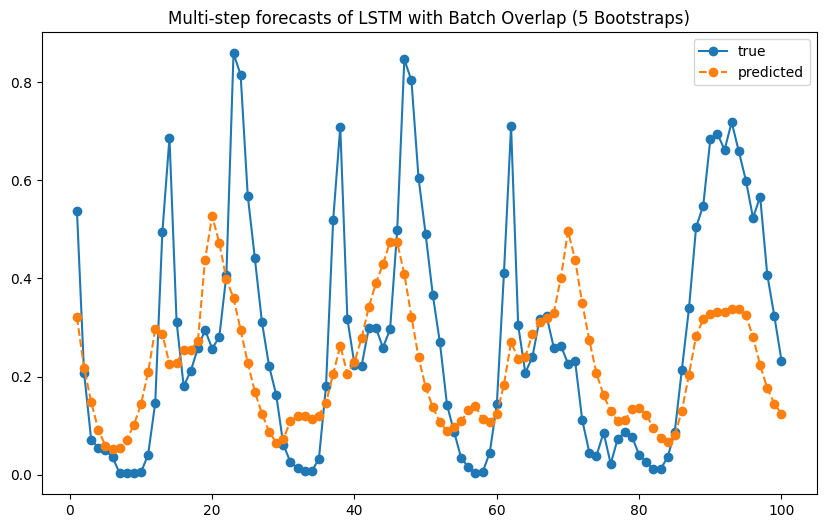

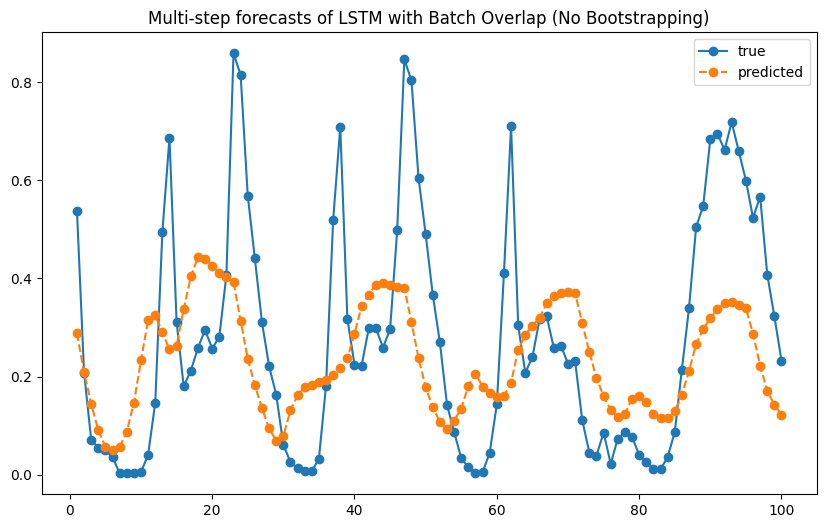

In [28]:
# plotting results for LSTM with Batch Overlap predictions

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 101), y_test[sequence_length - 1 :num_sequences + sequence_length - 1], label='true', marker='o', linestyle='-')
plt.plot(np.arange(1, 101), multi_step_forecasts[:100], label='predicted', marker='o', linestyle='--')

plt.title('Multi-step forecasts of LSTM with Batch Overlap (5 Bootstraps)')
plt.legend()
plt.show()

# plotting results for LSTM with Batch Overlap predictions (No Bootstrapping)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 101), y_test[sequence_length - 1 :num_sequences + sequence_length - 1], label='true', marker='o', linestyle='-')
plt.plot(np.arange(1, 101), multi_step_forecasts_no_bootstrap[:100], label='predicted', marker='o', linestyle='--')

plt.title('Multi-step forecasts of LSTM with Batch Overlap (No Bootstrapping)')
plt.legend()
plt.show()

In [29]:
import numpy as np
import keras

class SequenceDataGeneratorEncoderDecoder(keras.utils.Sequence):
    def __init__(self, data, targets, sequence_length, batch_size, prediction_size):
        self.data = data
        self.targets = targets
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.prediction_size = prediction_size

    def __len__(self):
        return (len(self.data) - self.sequence_length - self.prediction_size + 1) // self.batch_size

    def __getitem__(self, idx):
        start_index = idx * self.batch_size
        batch_x = []
        batch_y = []
        for i in range(start_index, start_index + self.batch_size):
            end_index = i + self.sequence_length
            y_end_index = end_index - 1 + self.prediction_size
            if end_index < len(self.data) and (y_end_index - 1) < len(self.targets):
                seq_x = self.data[i:end_index]
                seq_y = self.targets[end_index - 1:y_end_index]
                batch_x.append(seq_x)
                batch_y.append(seq_y)
        return np.array(batch_x), np.array(batch_y)
    def get_all_y_values(self):
        all_y_values = []
        for idx in range(len(self)):
            _, batch_y = self[idx]
            all_y_values.extend(batch_y)
        return np.array(all_y_values)

In [31]:
#Encoder Decoder LSTM Model
#reference https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/#:~:text=Implement%20Encoder%2DDecoder%20LSTMs%20in,encoded%20character%20at%20a%20time.

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from keras.layers import LSTM, RepeatVector
from keras.layers import TimeDistributed, Dense
import random

no_of_predictions = 100
sequence_length = 16
batch_size = 128

# splitting the data into train and test (70% and 30%)
split_point = int(len(hour_final) * 0.7)
train_set, future_test_set = train_test_split(hour_final, test_size=0.3, shuffle=False)
X_test = future_test_set[final_cols]
expected_shape_test = (X_test.shape[0] // 16) * 16

y_test = future_test_set[target]

# evaluation
test_generator = SequenceDataGeneratorEncoderDecoder(X_test.values, y_test.values, sequence_length, batch_size, no_of_predictions)

# for evaluation
ed_actual = test_generator.get_all_y_values()

# storing training and validation sets during bootstrapping
train_sets = []
val_sets = []

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers.legacy import Adam

# Initialize lists to store models and their predictions
ed_trained_models = []
ed_predictions = []

# Bootstrapping and training loop
bootstrap_samples = 5
for i in range(bootstrap_samples):
    # Sequential train-test split for time series data
    random_float = random.uniform(0, 0.2)

    # Calculate the start and end indices for the validation set
    total_length = len(train_set)
    val_start = int(total_length * random_float)
    val_end = int(total_length * (random_float + 0.8))

    # Ensure val_end does not exceed the total length of the dataset
    val_end = min(val_end, total_length)

    # Split the data into training and validation sets
    train_set_i = train_set[val_start:val_end]
    val_set = pd.concat([train_set[:val_start], train_set[val_end:]])

    '''
    # Bootstrap sampling
    train_bs = resample(train_set, replace=True)
    X_train = train_bs[final_cols]
    expected_shape_train = (X_train.shape[0] // 16) * 16
    y_train = train_bs[target]
    y_train_adjusted = y_train.values[15:expected_shape_train - 1].reshape(((y_train.shape[0] // 16) - 1, 16, 1))

    val_bs = train_set.loc[~train_set.index.isin(train_bs.index)]
    X_val = val_bs[final_cols]
    expected_shape_val = (X_val.shape[0] // 16) * 16
    y_val = val_bs[target]
    y_val_adjusted = y_val.values[15:expected_shape_val - 1].reshape(((y_val.shape[0] // 16) - 1, 16, 1))
    '''

    # Bootstrap sampling
    X_train = train_set_i[final_cols]
    y_train = train_set_i[target]
    y_train_adjusted = y_train[15:]
    train_generator = SequenceDataGeneratorEncoderDecoder(X_train.values, y_train.values, sequence_length, batch_size, no_of_predictions)

    X_val = val_set[final_cols]
    y_val = val_set[target]
    y_val_adjusted = y_val[15:]
    val_generator = SequenceDataGeneratorEncoderDecoder(X_val.values, y_val.values, sequence_length, batch_size, no_of_predictions)

    '''
    # Reshape data for LSTM
    X_train_reshaped = X_train.values[:expected_shape_train - 16].reshape(((X_train.shape[0] // 16) - 1, 16, X_train.shape[1]))
    X_val_reshaped = X_val.values[:expected_shape_val - 16].reshape(((X_val.shape[0] // 16) - 1, 16, X_val.shape[1]))
    '''

    # Build an encoder LSTM model
    model = Sequential()
    model.add(LSTM(units=64, input_shape=(sequence_length, X_train.shape[1]), dropout=0.5, return_sequences=True))
    model.add(LSTM(units=32, dropout=0.5))

    # Build a decoder LSTM model
    model.add(RepeatVector(no_of_predictions))
    model.add(LSTM(units=32, dropout=0.5, return_sequences=True))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the model
    model.fit(train_generator, epochs=128, validation_data=val_generator, shuffle=True)

    # Store the trained model
    ed_trained_models.append(model)

    model_predictions = model.predict(test_generator)
    ed_predictions.append(model_predictions)

    print("Finished sample " + str(i+1))


Epoch 1/128
74/74 [==============================] - 10s 104ms/step - loss: 0.0209 - val_loss: 0.0459
Epoch 2/128
74/74 [==============================] - 7s 100ms/step - loss: 0.0194 - val_loss: 0.0441
Epoch 3/128
74/74 [==============================] - 7s 99ms/step - loss: 0.0193 - val_loss: 0.0425
Epoch 4/128
74/74 [==============================] - 7s 100ms/step - loss: 0.0187 - val_loss: 0.0448
Epoch 5/128
74/74 [==============================] - 7s 99ms/step - loss: 0.0187 - val_loss: 0.0426
Epoch 6/128
74/74 [==============================] - 8s 102ms/step - loss: 0.0189 - val_loss: 0.0429
Epoch 7/128
74/74 [==============================] - 8s 102ms/step - loss: 0.0186 - val_loss: 0.0420
Epoch 8/128
74/74 [==============================] - 7s 100ms/step - loss: 0.0187 - val_loss: 0.0422
Epoch 9/128
74/74 [==============================] - 8s 102ms/step - loss: 0.0186 - val_loss: 0.0423
Epoch 10/128
74/74 [==============================] - 7s 100ms/step - loss: 0.0184 - val_los

In [32]:
from sklearn.metrics import median_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

# evaluation
def evaluate_pred_ed(predictions, actual):
  rmses, smapes, r_sqs, msaes, medaes, accs, precs, recalls, f1s = [], [], [], [], [], [], [], [], []

  act_flat = actual.flatten()

  yt = np.zeros_like(act_flat, dtype=int)

  for i in range(1, act_flat.shape[0]):
    if (act_flat[i] - act_flat[i-1] > 0):
      yt[i] = 1

  for pred in predictions:
    pred_flat = pred.flatten()

    yet = np.zeros_like(pred_flat, dtype=int)
    for i in range(1, pred_flat.shape[0]):
      if (pred_flat[i] - act_flat[i-1] > 0):
        yet[i] = 1

    errors = pred_flat - act_flat
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)

    smape = (100 / len(pred)) * np.sum(2 * np.abs(pred_flat - act_flat) / (np.abs(act_flat) + np.abs(pred_flat)))

    r_squared = r2_score(act_flat, pred_flat)

    mae = np.abs(errors).mean()

    medae = median_absolute_error(act_flat, pred_flat)

    acc = accuracy_score(yt, yet)

    prec = precision_score(yt, yet, average='binary')

    recall = recall_score(yt, yet, average='binary' )

    f1 = f1_score(yt, yet, average='binary' )

    rmses.append(rmse)
    smapes.append(smape)
    r_sqs.append(r_squared)
    msaes.append(mae)
    medaes.append(medae)
    accs.append(acc)
    precs.append(prec)
    recalls.append(recall)
    f1s.append(f1)

  rmse = np.mean(rmses)
  smape = np.mean(smapes)
  r_squared = np.mean(r_sqs)
  mae = np.mean(msaes)
  medae = np.mean(medaes)
  acc = np.mean(accs)
  prec = np.mean(precs)
  recall = np.mean(recalls)
  f1 = np.mean(f1s)

  return rmse, smape, r_squared, mae, medae, acc, prec, recall, f1

rmse, smape, r_squared, mae, medae, acc, prec, recall, f1 = evaluate_pred_ed(ed_predictions, ed_actual)

metrics_df = pd.DataFrame({
    "Metric": ["RMSE", "SMAPE", "R^2", "MAE", "MedAE", "Accuracy", "Precision", "Recall", "F1"],
    "Value": [100 * rmse, smape, r_squared, 100 * mae, 100 * medae, acc, prec, recall, f1]
})

print('Encoder-Decoder Model Evaluation (5 Bootstrap)')
print(metrics_df)
# loss = ed_trained_models[0].evaluate(X_test_reshaped, y_test_adjusted)
# print(f'Encoder-Decoder Model Loss on Test Set: {loss}')

Encoder-Decoder Model Evaluation (5 Bootstrap)
      Metric        Value
0       RMSE    18.337374
1      SMAPE  6497.530157
2        R^2     0.343652
3        MAE    12.606429
4      MedAE     7.989051
5   Accuracy     0.666308
6  Precision     0.651774
7     Recall     0.515673
8         F1     0.575059


In [33]:
rmse, smape, r_squared, mae, medae, acc, prec, recall, f1 = evaluate_pred_ed([ed_predictions[0]], ed_actual)

metrics_df = pd.DataFrame({
    "Metric": ["RMSE", "SMAPE", "R^2", "MAE", "MedAE", "Accuracy", "Precision", "Recall", "F1"],
    "Value": [100 * rmse, smape, r_squared, 100 * mae, 100 * medae, acc, prec, recall, f1]
})

print('Encoder-Decoder Model Evaluation (No Bootstrap)')
print(metrics_df)

Encoder-Decoder Model Evaluation (No Bootstrap)
      Metric        Value
0       RMSE    18.400031
1      SMAPE  6597.972786
2        R^2     0.339826
3        MAE    12.744257
4      MedAE     8.322567
5   Accuracy     0.682949
6  Precision     0.684303
7     Recall     0.512403
8         F1     0.586007


In [34]:
# generating multi-step forecasts for encoder-decoder model
def multistep_forecasts_ed(model, X, n_steps):
    current_step = 0
    forecasts = []
    sum_of_predictions = np.zeros((n_steps))
    for model_i in range(len(model)):
      forecast_step = model[model_i].predict(X.reshape(1, X.shape[0], X.shape[1]))
      sum_of_predictions += forecast_step.reshape(-1)
    forecasts = np.append(forecasts, sum_of_predictions / len(model))
    return np.array(forecasts)


In [35]:
# multi-step forecasts for Encoder Decoder LSTM
n_steps = 100
X_test_reshaped = X_test.values[:expected_shape_test].reshape((X_test.shape[0] // 16, 16, X_test.shape[1]))
multi_step_forecasts = multistep_forecasts_ed(ed_trained_models, X_test_reshaped[0], n_steps)

1/1 [==============================] - 0s 498ms/step


1/1 [==============================] - 1s 502ms/step


1/1 [==============================] - 1s 511ms/step


In [36]:
# multi-step forecasts for Encoder Decoder LSTM
n_steps = 100
X_test_reshaped = X_test.values[:expected_shape_test].reshape((X_test.shape[0] // 16, 16, X_test.shape[1]))
multi_step_forecasts_no_bootstrap = multistep_forecasts_ed(ed_trained_models[0:1], X_test_reshaped[0], n_steps)

1/1 [==============================] - 0s 16ms/step


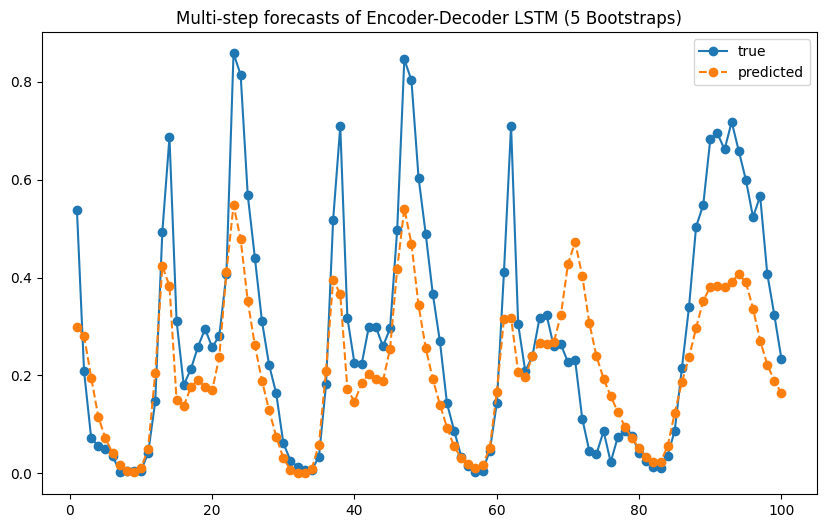

In [39]:
# plotting results for Encoder-Decoder LSTM predictions

# multi-step
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 101), y_test[sequence_length - 1 :num_sequences + sequence_length - 1], label='true', marker='o', linestyle='-')
plt.plot(np.arange(1, 101), multi_step_forecasts[:100], label='predicted', marker='o', linestyle='--')
plt.title('Multi-step forecasts of Encoder-Decoder LSTM (5 Bootstraps)')
plt.legend()
plt.show()

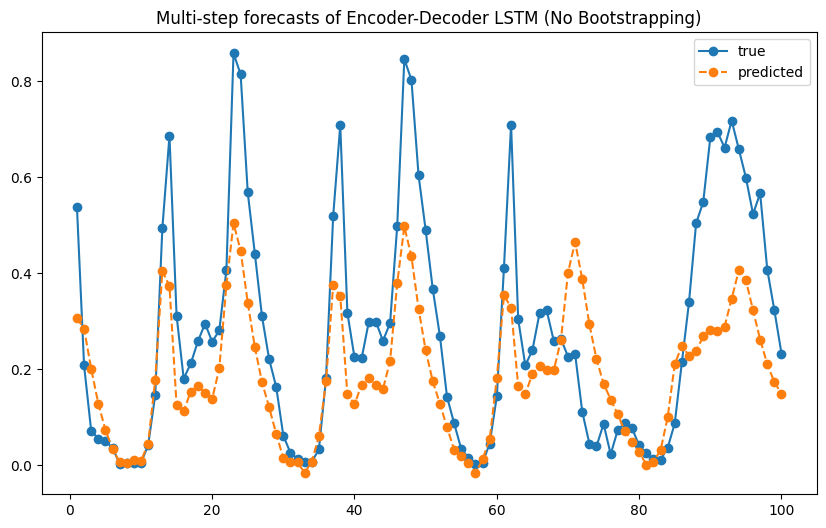

In [38]:
# plotting results for Encoder-Decoder LSTM predictions

# multi-step
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 101), y_test[sequence_length - 1 :num_sequences + sequence_length - 1], label='true', marker='o', linestyle='-')
plt.plot(np.arange(1, 101), multi_step_forecasts_no_bootstrap[:100], label='predicted', marker='o', linestyle='--')
plt.title('Multi-step forecasts of Encoder-Decoder LSTM (No Bootstrapping)')
plt.legend()
plt.show()